<a href="https://colab.research.google.com/github/MarcinAn/analiza_danych/blob/main/analiza_danych.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Pobieranie danych**

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
df= pd.read_csv('HRDataset.csv')

# **Czy istnieje zależność pomiędzy tym, kto jest bezpośrednim przełożonym (ManagerName, ManagerID) danego pracownika, a oceną wydajności pracy (PerformanceScore)?**

In [ ]:
manager_performance=df[{'ManagerName','PerformanceScore'}]
manager_performance.dropna(inplace=True)
manager_performance['PerformanceCount']=manager_performance['PerformanceScore']
manager_performance_pivot=manager_performance.pivot_table(values='PerformanceCount', index='ManagerName', columns='PerformanceScore', aggfunc='count').fillna(0)
manager_performance_pivot.reset_index(inplace=True)

<ipython-input-125-c503191410d5>:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
<ipython-input-125-c503191410d5>:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
<ipython-input-125-c503191410d5>:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
<ipython-input-125-c503191410d5>:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")


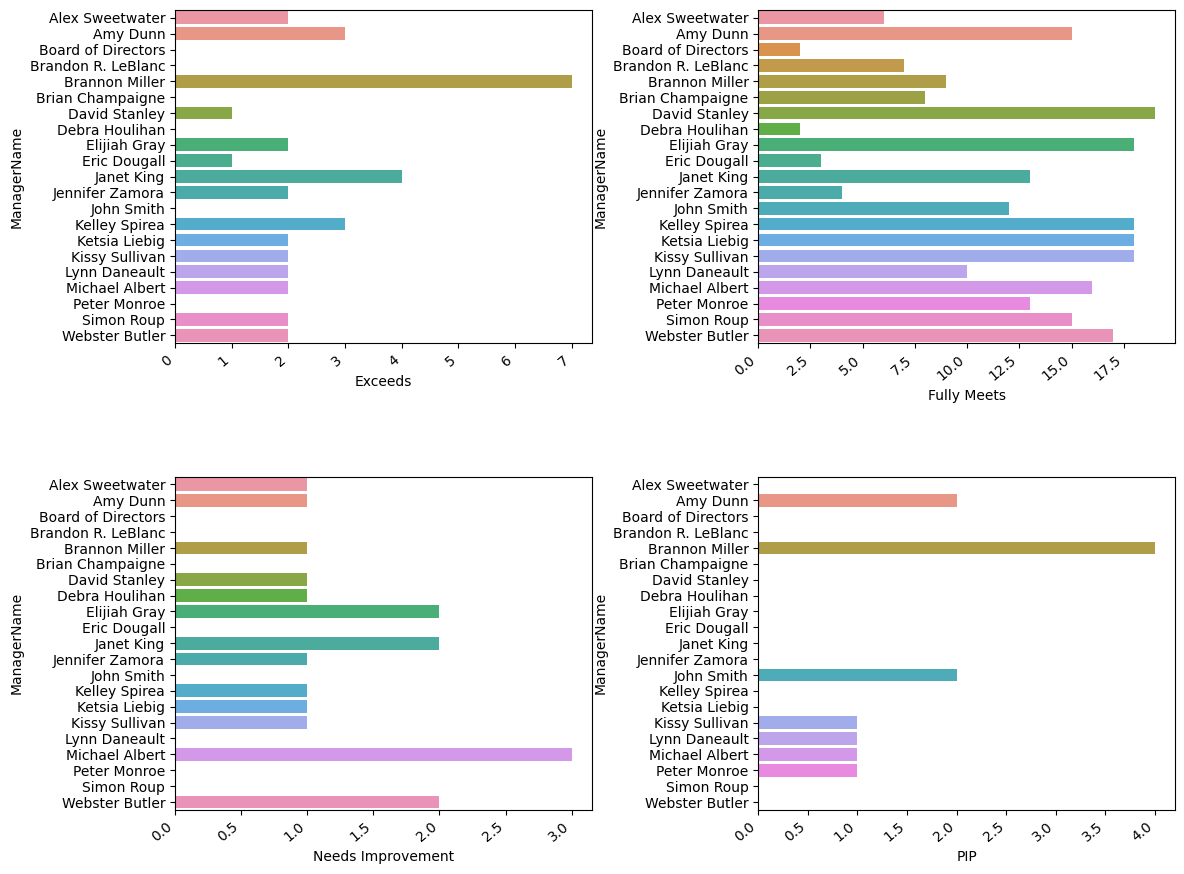

In [125]:
plt.figure(figsize=(10,10))
plt.subplots_adjust(left=0.1, bottom=0.1, right=1.1, top=0.9, wspace=0.4, hspace=0.4)

plt.subplot(2,2,1)
ax=sns.barplot(x=manager_performance_pivot['Exceeds'], y=manager_performance_pivot['ManagerName'])
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")

plt.subplot(2,2,2)
ax=sns.barplot(x=manager_performance_pivot['Fully Meets'], y=manager_performance_pivot['ManagerName'])
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")

plt.subplot(2,2,3)
ax=sns.barplot(x=manager_performance_pivot['Needs Improvement'], y=manager_performance_pivot['ManagerName'])
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")

plt.subplot(2,2,4)
ax=sns.barplot(x=manager_performance_pivot['PIP'], y=manager_performance_pivot['ManagerName'])
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")

plt.show()

***Do obgadania na spotkaniu***

---



# **Jakie źródła pozyskania pracownika (Recruitment Source) są najlepsze, jeśli zależy nam na jak najdłuższym stażu pracowników?**

In [4]:
recruitment_seniority=df[{'RecruitmentSource','DateofHire','DateofTermination'}]
recruitment_seniority.dropna(inplace=True)

<ipython-input-4-d893c7ae0017>:1: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  recruitment_seniority=df[{'RecruitmentSource','DateofHire','DateofTermination'}]
<ipython-input-4-d893c7ae0017>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recruitment_seniority.dropna(inplace=True)


In [5]:
recruitment_seniority['DateofTermination'] = pd.to_datetime(df['DateofTermination'],format='%m/%d/%y')
recruitment_seniority['DateofHire'] = pd.to_datetime(df['DateofHire'],format='%m/%d/%Y')

<ipython-input-5-279c2f252ec2>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recruitment_seniority['DateofTermination'] = pd.to_datetime(df['DateofTermination'],format='%m/%d/%y')
<ipython-input-5-279c2f252ec2>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recruitment_seniority['DateofHire'] = pd.to_datetime(df['DateofHire'],format='%m/%d/%Y')


In [6]:
import datetime as dt
def count_seniority(row):
    if pd.isnull(row['DateofTermination']):
        end_date = dt.datetime(2019,9,27)
    else:
        end_date = row['DateofTermination']
    return (end_date - row['DateofHire'])/np.timedelta64(1,'Y')

In [7]:
recruitment_seniority['Seniority'] = recruitment_seniority.apply(lambda row: count_seniority(row),axis=1)

<ipython-input-7-6fa5160e980a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recruitment_seniority['Seniority'] = recruitment_seniority.apply(lambda row: count_seniority(row),axis=1)


In [8]:
recruitment_seniority_pivot=recruitment_seniority.pivot_table(values='Seniority', index='RecruitmentSource', aggfunc='mean')
recruitment_seniority_pivot.reset_index(inplace=True)
recruitment_seniority_pivot.sort_values(by='Seniority', ascending=False, inplace=True)

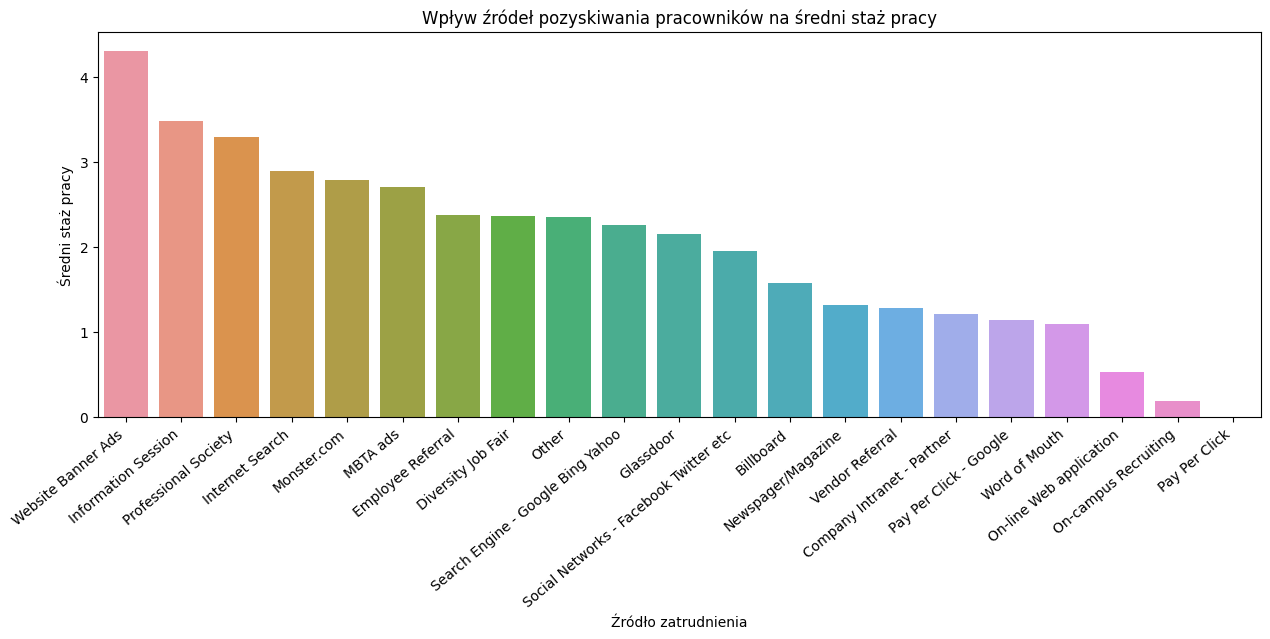

In [9]:
plt.figure(figsize=(15,5))
ax=sns.barplot(x='RecruitmentSource',y='Seniority',data=recruitment_seniority_pivot)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.xlabel('Źródło zatrudnienia')
plt.ylabel('Średni staż pracy')
plt.title('Wpływ źródeł pozyskiwania pracowników na średni staż pracy')
plt.show()

**Pracownicy z najdłuższym stażem pracy zostali pozyskani przy pomocy "Website Banner Ads"**

---



# **Czy stan cywilny (MartialDesc) pracownika koreluje w jakikolwiek sposób z zadowoleniem z pracy (EmpSatisfaction)?**

In [10]:
marital_satisfaction=df[{'MaritalDesc', 'EmpSatisfaction'}]
marital_satisfaction.dropna(inplace=True)
marital_satisfaction
marital_satisfaction_pivot=marital_satisfaction.pivot_table(values='EmpSatisfaction', index='MaritalDesc', aggfunc='mean')
marital_satisfaction_pivot.reset_index(inplace=True)
marital_satisfaction_pivot.sort_values(by='EmpSatisfaction',ascending=False,inplace=True)

<ipython-input-10-aab7b33544d0>:1: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  marital_satisfaction=df[{'MaritalDesc', 'EmpSatisfaction'}]
<ipython-input-10-aab7b33544d0>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  marital_satisfaction.dropna(inplace=True)


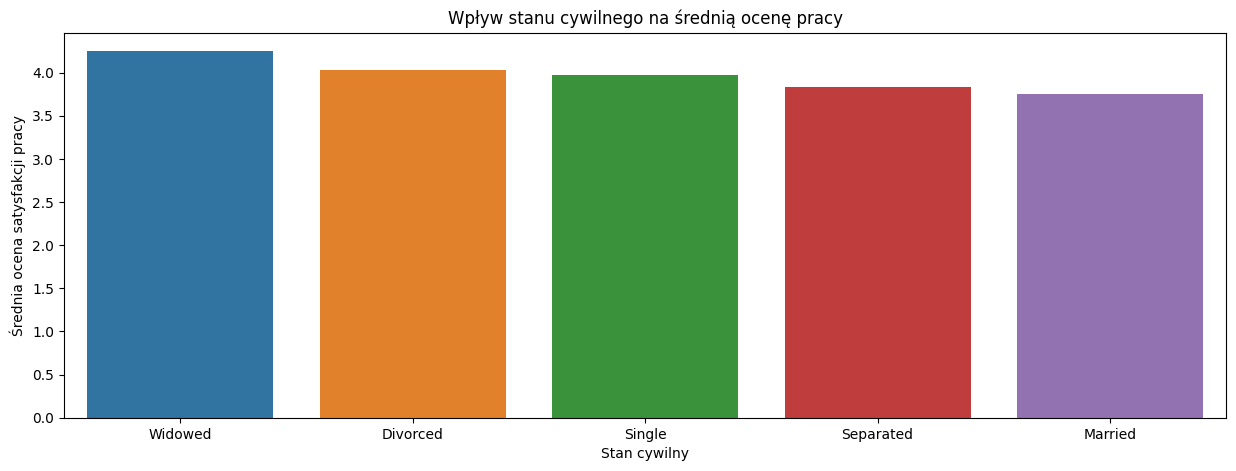

In [11]:
plt.figure(figsize=(15,5))
sns.barplot(x='MaritalDesc',y='EmpSatisfaction',data=marital_satisfaction_pivot)
plt.xlabel('Stan cywilny')
plt.ylabel('Średnia ocena satysfakcji pracy')
plt.title('Wpływ stanu cywilnego na średnią ocenę pracy')
plt.show()

In [66]:
print(round(marital_satisfaction_pivot.iloc[0,1]-marital_satisfaction_pivot.iloc[4,1],1))

0.5


**Różnica pomiędzy najlepiej oceniającymi swoją pracę "Windowed" a najgorzej oceniającymi "Married" wynosi około 0,5 punkta.**

---



# **Jak wygląda struktura wieku aktualnie zatrudnionych pracowników?**

In [12]:
age=df[{'DOB', 'DateofTermination','SpecialProjectsCount'}]
age.fillna(0, inplace=True)
age=age[age['DateofTermination']==0]
age.drop('DateofTermination', axis=1, inplace=True)
age=age[age['DOB']!=0]

<ipython-input-12-019563ecf496>:1: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  age=df[{'DOB', 'DateofTermination','SpecialProjectsCount'}]
<ipython-input-12-019563ecf496>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  age.fillna(0, inplace=True)


In [13]:
def fix_year(x):
  if (int(x[-2:]) > 23):
    return 1900 + int(x[-2:])
  else:
    return 2000 + int(x[-2:])
age['birth_year']=age['DOB'].apply(lambda x: fix_year(x))

In [14]:
age_pivot=age.pivot_table(values='DOB', index='birth_year', aggfunc='count')
age_pivot.reset_index(inplace=True)
age_pivot.sort_values(by='birth_year', inplace=True)

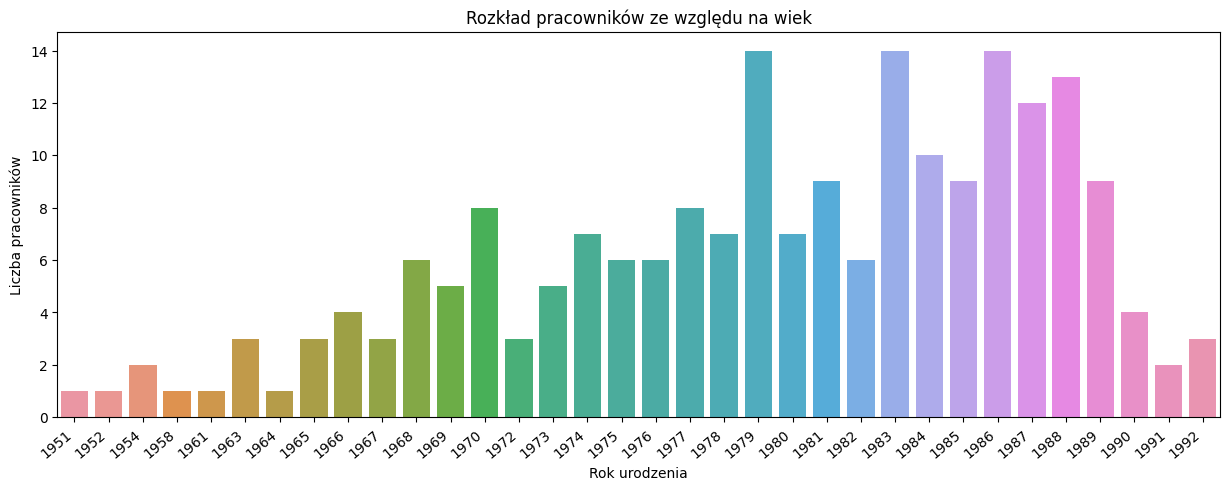

In [15]:
plt.figure(figsize=(15,5))
ax=sns.barplot(x='birth_year',y='DOB',data=age_pivot)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.xlabel('Rok urodzenia')
plt.ylabel('Liczba pracowników')
plt.title('Rozkład pracowników ze względu na wiek')
plt.show()

# **Czy starsi pracownicy pracują nad większą liczbą specjalnych projektów niż młodsi pracownicy?**

In [29]:
special_pivot=age.pivot_table(values='SpecialProjectsCount', index='birth_year', aggfunc='sum')
special_pivot.reset_index(inplace=True)
special_pivot.sort_values(by='birth_year', inplace=True)

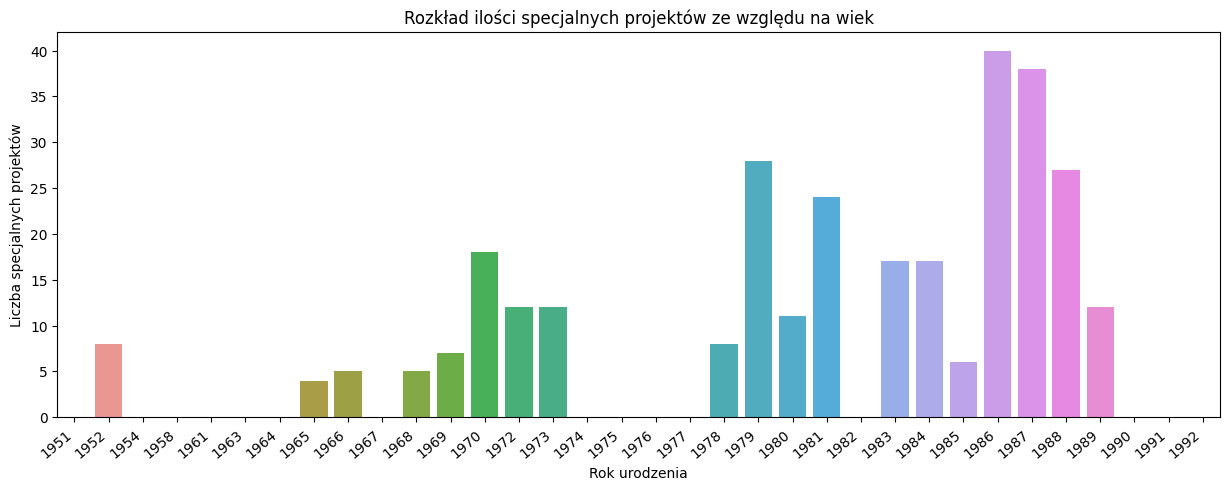

In [30]:
plt.figure(figsize=(15,5))
ax=sns.barplot(x='birth_year',y='SpecialProjectsCount',data=special_pivot)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.xlabel('Rok urodzenia')
plt.ylabel('Liczba specjalnych projektów')
plt.title('Rozkład ilości specjalnych projektów ze względu na wiek')
plt.show()

**Pracownicy urodzeni w roku 1979 i później pracują nad większą ilością specjalnych projektów.**

---

